In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib


import sys
import os

# De-anonymizing stock_id

This notebook attempts to match stock_id used in Optiver - Trading at the Close dataset to the actual NASDAQ symbols. The idea is to:
* Find the tick size expressed in wap returns
* Convert that to price in USD
* Compare to actual NASDAQ data (close price)
* Find the stock_id<->symbol and date_id<->date mapping that minimizes the difference between the inferred price and NASDAQ closing price time series. 


Not every stock ID is a good match, and date ID is likely off by a day or two, so use this your own risk.

In [2]:
tldr = {166: 'KHC', 121: 'KDP', 105: 'MDLZ', 151: 'CSCO', 170: 'HOLX', 0: 'MNST', 65: 'EXC', 109: 'CSX', 123: 'GILD', 198: 'CMCSA', 131: 'INCY', 21: 'SSNC', 148: 'XEL', 38: 'ATVI', 30: 'LNT', 63: 'LKQ', 24: 'AKAM', 130: 'SBUX', 120: 'FOXA', 195: 'AEP', 53: 'EBAY', 81: 'SGEN', 47: 'TXRH', 154: 'DBX', 160: 'PEP', 55: 'FAST', 37: 'ADP', 90: 'FFIV', 186: 'CTSH', 187: 'EA', 76: 'HAS', 117: 'AGNC', 134: 'VTRS', 3: 'HON', 165: 'HST', 97: 'NBIX', 145: 'CG', 25: 'EXPD', 68: 'PAYX', 52: 'CINF', 112: 'LSTR', 181: 'JBHT', 28: 'FANG', 43: 'JKHY', 12: 'AMGN', 149: 'VRSK', 144: 'PCAR', 192: 'PTC', 153: 'HTZ', 175: 'GOOGL', 189: 'CSGP', 116: 'CDW', 35: 'ROST', 46: 'TECH', 164: 'CPRT', 44: 'CME', 146: 'MIDD', 125: 'UTHR', 171: 'TROW', 73: 'GEN', 196: 'XRAY', 9: 'PFG', 199: 'BKR', 193: 'PYPL', 106: 'TRMB', 122: 'AAL', 4: 'MAR', 176: 'FTNT', 2: 'AXON', 167: 'CHRW', 91: 'DOCU', 128: 'WDC', 152: 'SBAC', 155: 'CHK', 26: 'HBAN', 132: 'TSCO', 119: 'MASI', 27: 'QRVO', 84: 'GOOGL', 23: 'SWKS', 110: 'TMUS', 182: 'UAL', 157: 'ADSK', 168: 'AMZN', 147: 'APA', 64: 'MKTX', 190: 'DXCM', 19: 'ALNY', 1: 'WING', 49: 'FITB', 194: 'PENN', 140: 'TXN', 133: 'ISRG', 177: 'SWAV', 32: 'NTAP', 22: 'ON', 77: 'VRTX', 104: 'WBA', 107: 'PODD', 59: 'Z', 72: 'ADI', 158: 'APLS', 169: 'MSFT', 94: 'PCTY', 66: 'LBRDK', 126: 'MU', 139: 'EXPE', 159: 'STLD', 137: 'TTWO', 78: 'HOOD', 114: 'LPLA', 141: 'AMAT', 15: 'ABNB', 60: 'CRWD', 183: 'MCHP', 10: 'NDAQ', 135: 'DKNG', 197: 'SPLK', 99: 'PARA', 56: 'ETSY', 13: 'TER', 62: 'RGEN', 80: 'TXG', 67: 'MRNA', 178: 'ZM', 39: 'CTAS', 173: 'FIVE', 184: 'DDOG', 162: 'ENPH', 16: 'ZBRA', 89: 'ENTG', 45: 'MSFT', 124: 'ASO', 42: 'SAIA', 115: 'ILMN', 50: 'MTCH', 98: 'JBLU', 103: 'ZS', 40: 'CZR', 108: 'SEDG', 179: 'META', 6: 'POOL', 100: 'MQ', 48: 'WDAY', 150: 'PANW', 74: 'ALGN', 113: 'LULU', 163: 'COST', 111: 'SPWR', 36: 'DLTR', 85: 'CAR', 79: 'WBD', 83: 'INTC', 75: 'CDNS', 57: 'IDXX', 180: 'GH', 93: 'ZION', 87: 'LSCC', 51: 'ROKU', 33: 'CROX', 58: 'ROP', 7: 'LRCX', 172: 'APP', 61: 'LYFT', 185: 'ODFL', 102: 'TEAM', 188: 'RUN', 17: 'KLAC', 88: 'NFLX', 95: 'AMD', 14: 'ADBE', 54: 'SNPS', 18: 'ZI', 129: 'CFLT', 136: 'LITE', 191: 'TSLA', 20: 'ULTA', 161: 'PTON', 5: 'OKTA', 71: 'EQIX', 34: 'REGN', 142: 'AVGO', 92: 'MSTR', 156: 'LCID', 41: 'NVDA', 69: 'SOFI', 138: 'SMCI', 174: 'AFRM', 11: 'COIN', 70: 'BYND', 96: 'MRVL', 118: 'FCNCA', 29: 'ORLY', 143: 'TLRY', 86: 'ONEW', 82: 'OPEN', 127: 'MDB', 101: 'FCNCA', 8: 'BKNG', 31: 'NVCR'}
print("tl;dr:")
print(tldr)

tl;dr:
{166: 'KHC', 121: 'KDP', 105: 'MDLZ', 151: 'CSCO', 170: 'HOLX', 0: 'MNST', 65: 'EXC', 109: 'CSX', 123: 'GILD', 198: 'CMCSA', 131: 'INCY', 21: 'SSNC', 148: 'XEL', 38: 'ATVI', 30: 'LNT', 63: 'LKQ', 24: 'AKAM', 130: 'SBUX', 120: 'FOXA', 195: 'AEP', 53: 'EBAY', 81: 'SGEN', 47: 'TXRH', 154: 'DBX', 160: 'PEP', 55: 'FAST', 37: 'ADP', 90: 'FFIV', 186: 'CTSH', 187: 'EA', 76: 'HAS', 117: 'AGNC', 134: 'VTRS', 3: 'HON', 165: 'HST', 97: 'NBIX', 145: 'CG', 25: 'EXPD', 68: 'PAYX', 52: 'CINF', 112: 'LSTR', 181: 'JBHT', 28: 'FANG', 43: 'JKHY', 12: 'AMGN', 149: 'VRSK', 144: 'PCAR', 192: 'PTC', 153: 'HTZ', 175: 'GOOGL', 189: 'CSGP', 116: 'CDW', 35: 'ROST', 46: 'TECH', 164: 'CPRT', 44: 'CME', 146: 'MIDD', 125: 'UTHR', 171: 'TROW', 73: 'GEN', 196: 'XRAY', 9: 'PFG', 199: 'BKR', 193: 'PYPL', 106: 'TRMB', 122: 'AAL', 4: 'MAR', 176: 'FTNT', 2: 'AXON', 167: 'CHRW', 91: 'DOCU', 128: 'WDC', 152: 'SBAC', 155: 'CHK', 26: 'HBAN', 132: 'TSCO', 119: 'MASI', 27: 'QRVO', 84: 'GOOGL', 23: 'SWKS', 110: 'TMUS', 182:

In [3]:
FILE = "/kaggle/input/optiver-trading-at-the-close/train.csv"
sample_data = pd.read_csv(FILE)

## Inspect price return difference

In [4]:
sample_data.query("stock_id==1 and date_id==4").bid_price.diff().abs().value_counts()

bid_price
0.000000    24
0.000340     5
0.000397     4
0.000170     3
0.000057     3
0.000396     2
0.000227     2
0.000114     2
0.000113     2
0.000624     1
0.000850     1
0.000226     1
0.001643     1
0.000283     1
0.000056     1
0.000510     1
Name: count, dtype: int64

In [5]:
sample_data["bid_price_diff"] = sample_data.groupby(["date_id", "stock_id"]).bid_price.diff().abs()
sample_data["ask_price_diff"] = sample_data.groupby(["date_id", "stock_id"]).ask_price.diff().abs()


Get the minimum price difference for a given day, and assume that this corresponds to the tick size.

In [6]:
tick_size_est_1 = sample_data[sample_data.bid_price_diff>0].groupby(["date_id", "stock_id"]).bid_price_diff.min().rename("tick_est_bid").to_frame()
tick_size_est_2 = sample_data[sample_data.ask_price_diff>0].groupby(["date_id", "stock_id"]).ask_price_diff.min().rename("tick_est_ask")
tick_size_est = tick_size_est_1.join(tick_size_est_2)
tick_size_est["tick_size_min"] = tick_size_est.min(1)
tick_size_est["price_est"] = 0.01 / tick_size_est.tick_size_min


In [7]:
wide_est = pd.pivot(tick_size_est.reset_index(), index="date_id", values="price_est", columns="stock_id").fillna(method="ffill")

Text(0, 0.5, 'inferred price')

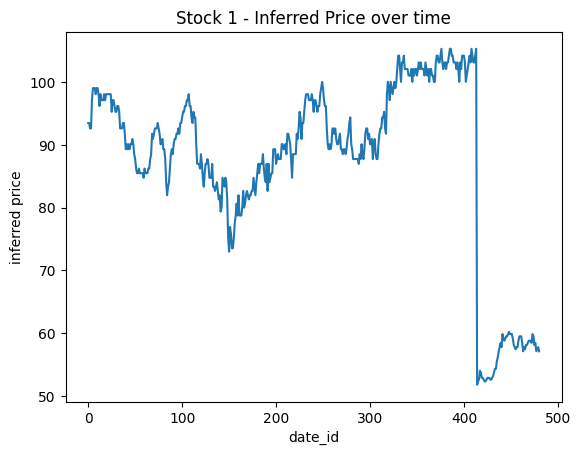

In [8]:
import matplotlib.pyplot as plt

plt.plot(wide_est.index, wide_est[0])
plt.title("Stock 1 - Inferred Price over time")

plt.xlabel("date_id")
plt.ylabel("inferred price")

## Load Stock data

This is from https://www.kaggle.com/datasets/svaningelgem/nasdaq-daily-stock-prices/ by @svaningelgem.

In [9]:
import glob
all_stock_data = []
for s in glob.glob("/kaggle/input/nasdaq-daily-stock-prices/*.csv"):
    df = pd.read_csv(s, dtype={"ticker": str}).query("date>'2020-01-01' ") # and date<'2021-08-04' ")
    if len(df)>0:
        all_stock_data.append(df)
    
all_stock_data = pd.concat(all_stock_data)

all_stock_data = all_stock_data.dropna(subset=["ticker"])

## Step 1: Find MSFT

I decided to first find whether any of the stocks would correspond to MSFT. The reason I picked MSFT was that (1) it's a big part of NASDAQ 100 (2) its last split was on 2003-02-18, so if needed I can go back last 20 years without worrying about correcting for splits.

I tried fancier ways of comparing time series, but at the end what worked best was to slide a window of size 481 in increments of 100 and pick the stock ID minimizing the Euclidean distance.

In [10]:
actual_stocks = pd.Series(all_stock_data.ticker.unique()).sort_values()
actual_stocks = ["MSFT"]

sid_to_name = {}

name_to_sid = {}

all_scores = []

lag = 0
for s in actual_stocks:
    distances = []
    stock_lag = []
    actual = all_stock_data.loc[all_stock_data.ticker==s]

    for lag in np.arange(0,1000,100):    
        lagged_s = actual.iloc[lag:]
        lagged_s = lagged_s.close.values[0:481]
        if len(lagged_s) < 481:
            continue

        for i in range(0,200):
            c = np.linalg.norm(lagged_s - wide_est[i].values, 2) / lagged_s.mean()
            c = c if c==c else np.inf
            distances.append(c)
            stock_lag.append((i,lag))

        idx = np.argmin(distances)
        sid, lag = stock_lag[idx]
        min_distance = min(distances)
        all_scores.append([s, sid, min_distance])

# print(min(distances), stock_lag[idx])
msft = stock_lag[idx][0]
approx_lag = stock_lag[idx][1]

print(f"Stock ID={msft}, Lag={approx_lag}")

Stock ID=45, Lag=400


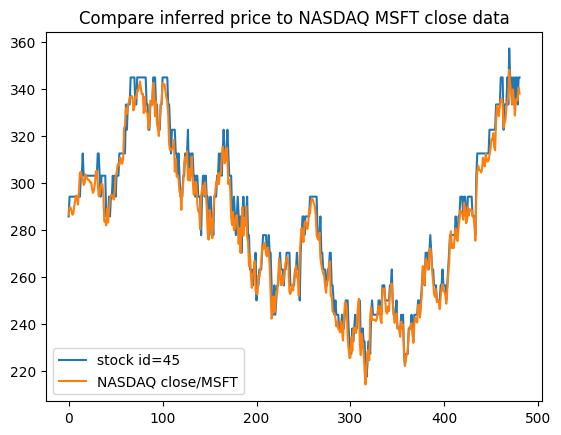

In [11]:
plt.plot(wide_est[msft])
plt.plot(np.arange(0,481), actual.close.values[approx_lag:approx_lag+481])
plt.title("Compare inferred price to NASDAQ MSFT close data")
plt.legend([f"stock id={msft}", "NASDAQ close/MSFT"])

The date id lag value 400 appears to be a good visual match, but the code below tries to minimize the distance by checking nearby values as well.

# Find optimal date for MSFT

In [12]:
actual_stocks = pd.Series(all_stock_data.ticker.unique()).sort_values()
actual_stocks = ["MSFT"]

sid_to_name = {}
name_to_sid = {}
all_scores = []

lag = 0
for s in actual_stocks:
    distances = []
    stock_lag = []
    actual = all_stock_data.loc[all_stock_data.ticker==s]
    for lag in np.arange(300,500):            
        lagged_s = actual.iloc[lag:]
        lagged_s = lagged_s.close.values[0:481]
        if len(lagged_s) < 481:
            continue

        for i in [msft]:
            c = np.linalg.norm(lagged_s - wide_est[i].values[::1], 2) / lagged_s.mean()
            c = c if c==c else np.inf
            distances.append(c)
            stock_lag.append((i,lag))

        idx = np.argmin(distances)

        sid, lag = stock_lag[idx]
        min_distance = min(distances)
        all_scores.append([s, sid, min_distance])


idx = np.argmin(distances)
print(min(distances), stock_lag[idx])
best_lag = stock_lag[idx][1]
date0 = actual.iloc[best_lag].date
print(f"Date corresponding to date_id=0: {date0}")

0.43584229138475356 (45, 399)
Date corresponding to date_id=0: 2021-08-03


## Map date ID to date

In [13]:
import datetime

def align_dates(dates, d0):
    index = dates[dates==d0].index[0]
    date_to_date_id = {d:i-index for i,d in enumerate(sorted(dates))}
    date_id_to_date= {i-index:d for i,d in enumerate(sorted(dates))}
    return date_id_to_date, date_to_date_id

# date0_dt = datetime.date.fromisoformat(date0)
dates = actual.date[actual.date>=date0][0:481].reset_index(drop=True)
date_id_to_date, date_to_date_id = align_dates(dates, date0)

In [14]:
dates

0      2021-08-03
1      2021-08-04
2      2021-08-05
3      2021-08-06
4      2021-08-09
          ...    
476    2023-06-26
477    2023-06-27
478    2023-06-28
479    2023-06-29
480    2023-06-30
Name: date, Length: 481, dtype: object

## Find the best match symbol for all stocks - check last N days only

Now that we have a date/date_id mapping, we can find a match for the remaining stocks. I limit the search to the time between date_id=450 and date_id=481. This is to minimize the effects of splits.

In [15]:
import tqdm

REF_INDEX = 0
actual_stocks = pd.Series(all_stock_data.ticker.unique()).sort_values()

sid_to_name = {}
name_to_sid = {}
all_scores = []

min_date_id = 450
date1 = date_id_to_date[min_date_id]
max_date_id = 481
size = max_date_id - min_date_id

for s in tqdm.tqdm(actual_stocks):
    distances = []
    stock_lag = []
    
    size = max_date_id - min_date_id
    date1 = date_id_to_date[min_date_id]

    actual = all_stock_data.loc[all_stock_data.ticker==s]
    actual = actual[actual.date>=str(date1)]

    lagged_s = actual.close.values[0:size]        
    if len(lagged_s) < size:            
        continue

    for i in range(0,200):
        c = np.linalg.norm(lagged_s - wide_est[i].fillna(0).values[min_date_id:max_date_id], 2) / lagged_s.mean()
        c = c if c==c else np.inf
        all_scores.append([s, i, c]) 


100%|██████████| 3490/3490 [13:54<00:00,  4.18it/s]


In [16]:
score_df = pd.DataFrame(all_scores)
score_df.columns = ["ticker", "stock_id", "distance"]

ix=score_df.groupby("stock_id").distance.apply("idxmin")
score_df.loc[ix]

pd.options.display.max_rows = 200
best_df = score_df.loc[ix].sort_values(by="distance")
best_df.sample(20)

,ticker,stock_id,distance
398064,MKTX,64,0.116666
130967,CHRW,167,0.107815
468150,PANW,150,0.162535
3215,ABNB,15,0.136551
471944,PCAR,144,0.090511
622191,TSLA,191,0.223277
317683,INTC,83,0.169447
66542,AVGO,142,0.266966
655277,VRTX,77,0.124695
87208,BKNG,8,1.232663


In [17]:
print("Duplicated:")
best_df[best_df.ticker.duplicated(False)]

Duplicated:


,ticker,stock_id,distance
267375,GOOGL,175,0.090681
267284,GOOGL,84,0.112587
410769,MSFT,169,0.129067
410645,MSFT,45,0.151892
224118,FCNCA,118,0.323421
224101,FCNCA,101,0.704271


In [18]:
tldr = best_df.set_index("stock_id").ticker.to_dict()
print(tldr)

{166: 'KHC', 121: 'KDP', 105: 'MDLZ', 151: 'CSCO', 170: 'HOLX', 0: 'MNST', 65: 'EXC', 109: 'CSX', 123: 'GILD', 198: 'CMCSA', 131: 'INCY', 21: 'SSNC', 148: 'XEL', 38: 'ATVI', 30: 'LNT', 63: 'LKQ', 24: 'AKAM', 130: 'SBUX', 120: 'FOXA', 195: 'AEP', 53: 'EBAY', 81: 'SGEN', 47: 'TXRH', 154: 'DBX', 160: 'PEP', 55: 'FAST', 37: 'ADP', 90: 'FFIV', 186: 'CTSH', 187: 'EA', 76: 'HAS', 117: 'AGNC', 134: 'VTRS', 3: 'HON', 165: 'HST', 97: 'NBIX', 145: 'CG', 25: 'EXPD', 68: 'PAYX', 52: 'CINF', 112: 'LSTR', 181: 'JBHT', 28: 'FANG', 43: 'JKHY', 12: 'AMGN', 149: 'VRSK', 144: 'PCAR', 192: 'PTC', 153: 'HTZ', 175: 'GOOGL', 189: 'CSGP', 116: 'CDW', 35: 'ROST', 46: 'TECH', 164: 'CPRT', 44: 'CME', 146: 'MIDD', 125: 'UTHR', 171: 'TROW', 73: 'GEN', 196: 'XRAY', 9: 'PFG', 199: 'BKR', 193: 'PYPL', 106: 'TRMB', 122: 'AAL', 4: 'MAR', 176: 'FTNT', 2: 'AXON', 167: 'CHRW', 91: 'DOCU', 128: 'WDC', 152: 'SBAC', 155: 'CHK', 26: 'HBAN', 132: 'TSCO', 119: 'MASI', 27: 'QRVO', 84: 'GOOGL', 23: 'SWKS', 110: 'TMUS', 182: 'UAL',

Note that the matching is not exactly one-to-one. This could be due to different asset classes (such as GOOG vs GOOGL - the source dataset only contains GOOGL).

# Visual Comparison

In [19]:
all_stock_data["date_id"] = all_stock_data.date.map(date_to_date_id)
all_stock_data["stock_id"] =  all_stock_data.ticker.map(best_df.set_index("ticker").stock_id.to_dict())

In [20]:
all_stock_data_with_tick_est = all_stock_data.merge(tick_size_est, left_on=["date_id", "stock_id"], right_index=True)

NASDAQ data (blue) vs reverse engineered price (red). Some stocks don't match well, such as stock_id=8.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


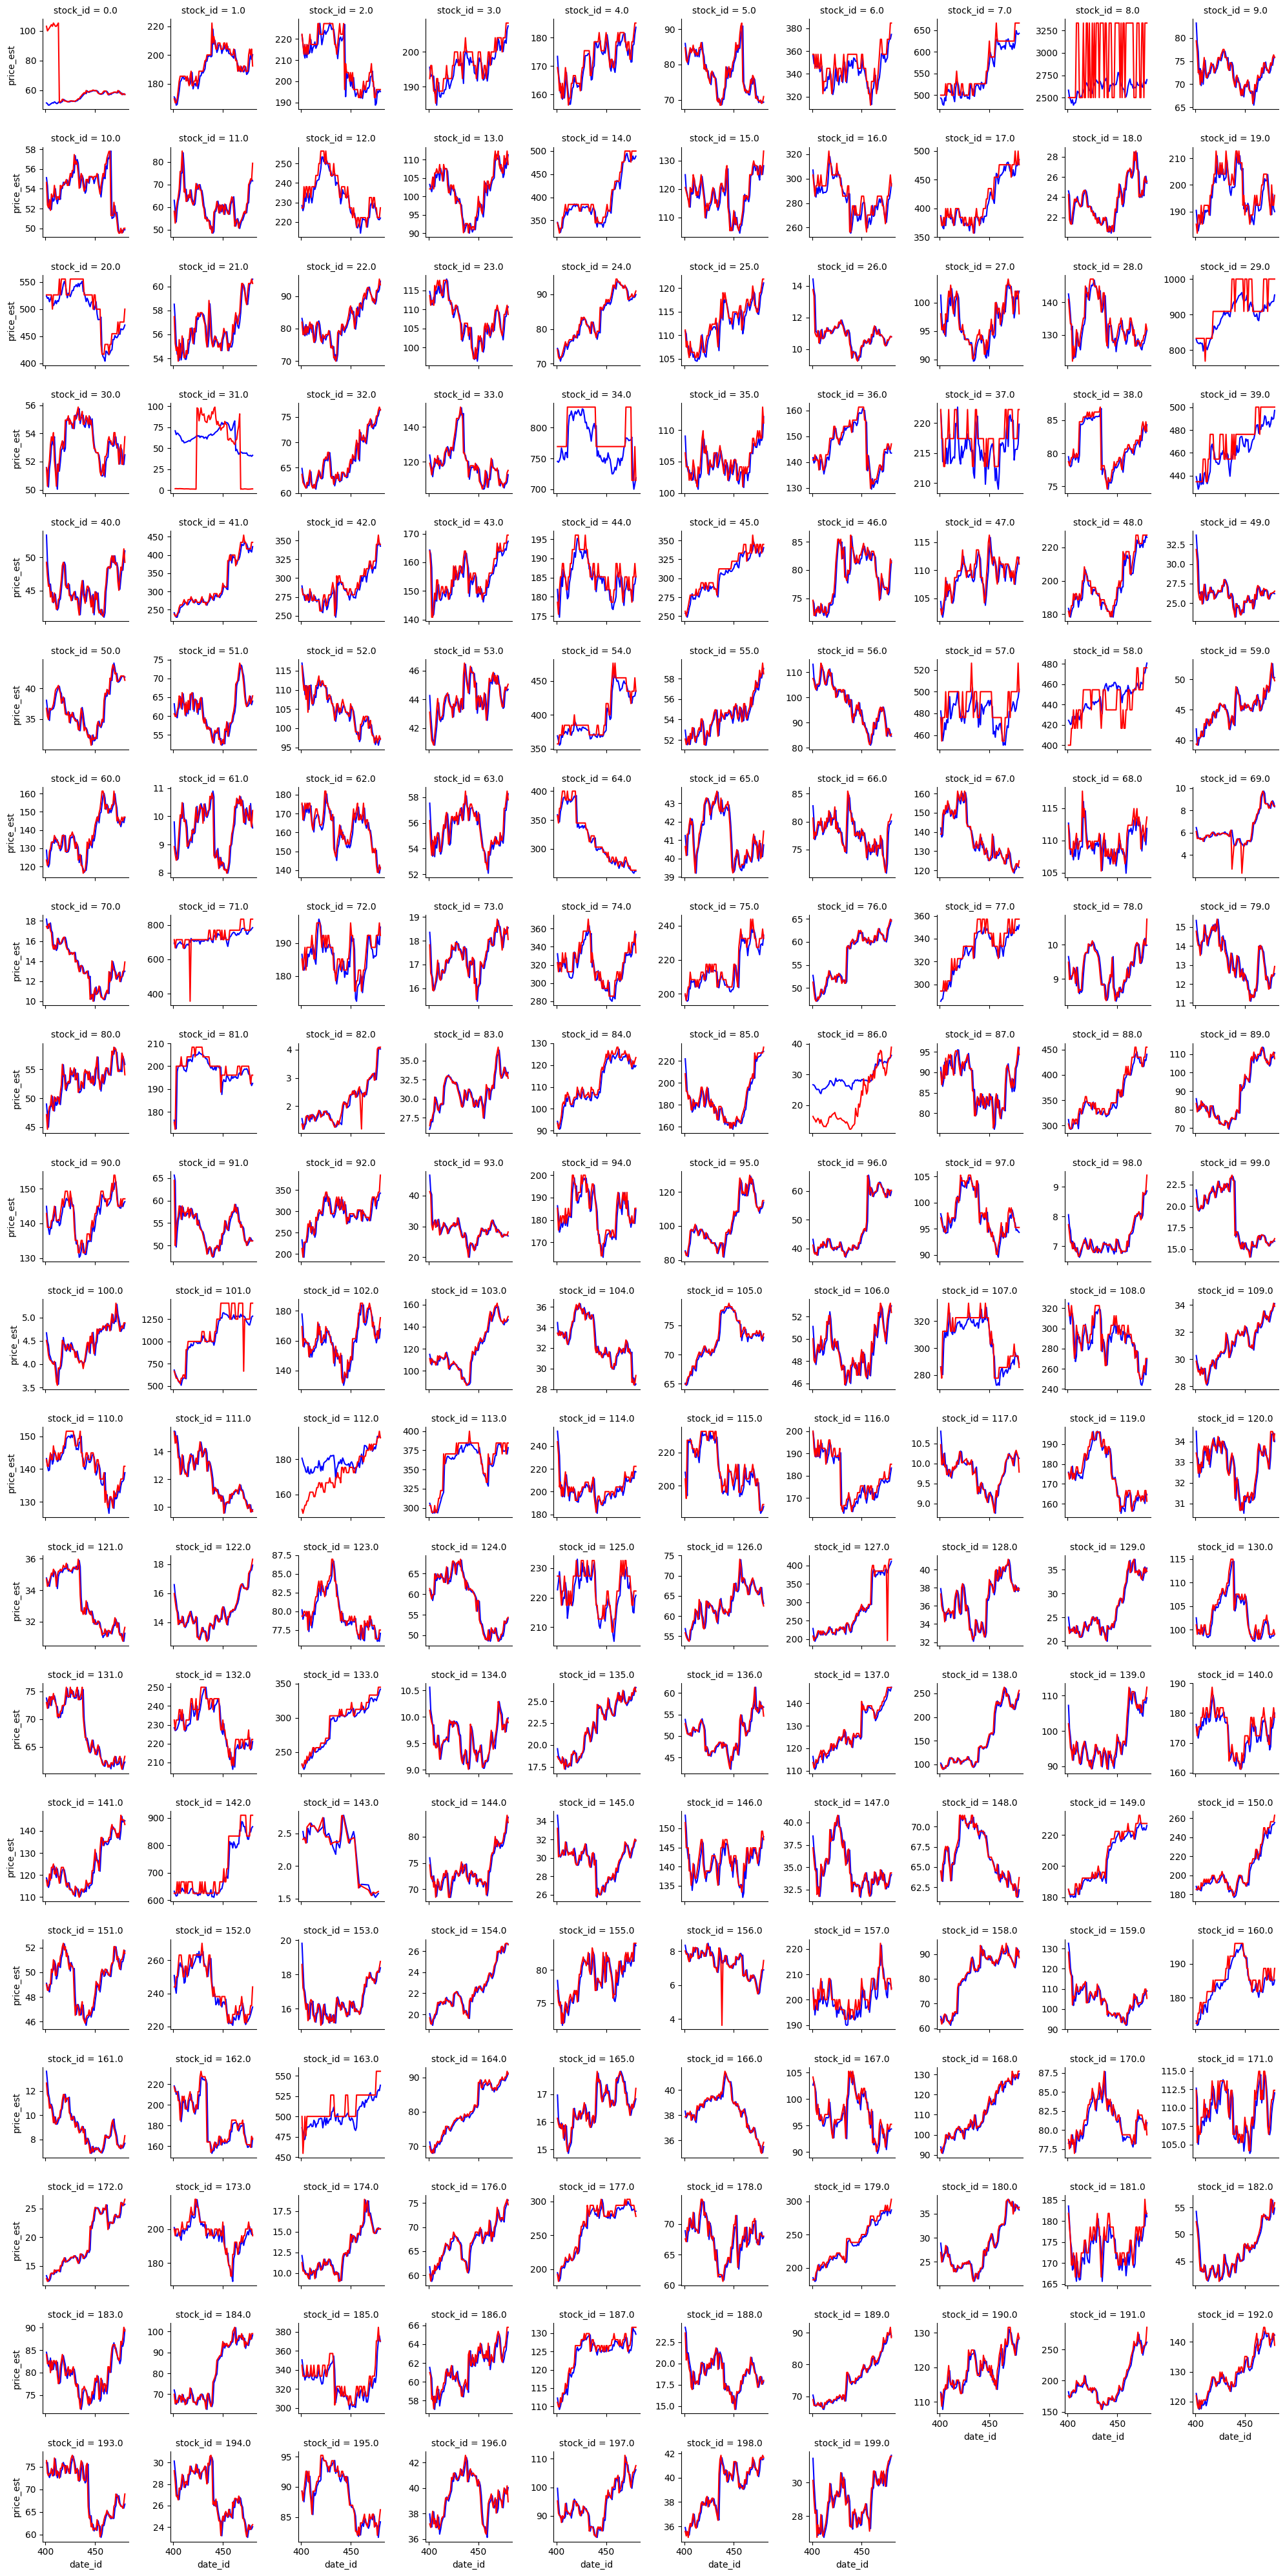

In [21]:
g = sns.FacetGrid(data=all_stock_data_with_tick_est.query("date_id>400"), col="stock_id", col_wrap=10, height=2, sharey=False)
g.map(plt.plot, "date_id", "close", color="b")
g.map(plt.plot, "date_id", "price_est", color="r")

## Credits / Further reading

[@svaningelgem](https://www.kaggle.com/svaningelgem) for the NASDAQ dataset

https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/457721 about making use of splits and bid/ask size fields.